In [41]:
# 회귀모형 
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 

# 쓸데없는 알림 방지
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import itertools

#통계적 모형
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#머신러닝
from sklearn import datasets
from sklearn import metrics
from sklearn import svm, neighbors, tree 

from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error #연속형일때 사용하는 경우 
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix #범주형(분류모델)

from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer,MinMaxScaler # scale

In [42]:
titanic_raw_data = pd.read_csv('C:/Users/scien/Videos/titanic/titanic_full_data.csv')

In [43]:
titanic_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1285 non-null   int64  
 1   Survived     1285 non-null   int64  
 2   Pclass       1285 non-null   int64  
 3   Name         1285 non-null   object 
 4   Sex          1285 non-null   object 
 5   Age          1030 non-null   float64
 6   SibSp        1285 non-null   int64  
 7   Parch        1285 non-null   int64  
 8   Ticket       1285 non-null   object 
 9   Fare         1284 non-null   float64
 10  Cabin        294 non-null    object 
 11  Embarked     1283 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 120.6+ KB


### 결측치, 문자열 데이터를 어떻게 전처리 해야하는가? 

- PassengerId (index)
- Name (지워버림)
- sex (원핫 인코딩으로 수치화)
- Ticket (지움)
- Cabin (빼줘)
- Embark (원핫 인코딩으로 수치화)

In [44]:
# 반응변수 Y를 만들자 
titanic_target = titanic_raw_data['Survived']

In [45]:
titanic_target

0       0
1       1
2       1
3       1
4       0
       ..
1280    0
1281    1
1282    0
1283    0
1284    1
Name: Survived, Length: 1285, dtype: int64

In [46]:
# Y 해당하는 survived 제외, 문자열 타입 Name, Cabin 제외 
columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare', 'Embarked']

In [47]:
# 입력변수 X를 만들자 
titanic_features = titanic_raw_data[columns]
titanic_features

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
1280,3,male,NaN,0,0,8.0500,S
1281,1,female,39.0,0,0,108.9000,C
1282,3,male,38.5,0,0,7.2500,S
1283,3,male,NaN,0,0,8.0500,S


In [48]:
# 문자열 자료를 이산형으로 만들기 
# 굳이 2개 다 쓸 필요가 없어 하나만 이용할 것임 drop_first = True
# 만일 female을 남기고 싶다면?
# columns=['male', 'female']

titanic_features[['feamle', 'male']] = pd.get_dummies(titanic_features['Sex'])

In [49]:
titanic_features.drop(columns=['Sex'], inplace=True)

In [50]:
titanic_features

,Pclass,Age,SibSp,Parch,Fare,Embarked,feamle,male
0,3,22.0,1,0,7.2500,S,0,1
1,1,38.0,1,0,71.2833,C,1,0
2,3,26.0,0,0,7.9250,S,1,0
3,1,35.0,1,0,53.1000,S,1,0
4,3,35.0,0,0,8.0500,S,0,1
...,...,...,...,...,...,...,...,...
1280,3,NaN,0,0,8.0500,S,0,1
1281,1,39.0,0,0,108.9000,C,1,0
1282,3,38.5,0,0,7.2500,S,0,1
1283,3,NaN,0,0,8.0500,S,0,1


In [51]:
titanic_features['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [52]:
dummy_columns = pd.get_dummies(titanic_features['Embarked'], prefix='Embarked').columns

In [53]:
titanic_features[dummy_columns] = pd.get_dummies(titanic_features['Embarked'], prefix='Embarked')

In [54]:
titanic_features.drop(columns=['Embarked'], inplace=True)

In [55]:
# pd.cut(data, bins, label) n개의 구간별로 나누기 pd.cut

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80] # 시작과 끝값을 지정
labels = ['child', 'teens', '20s', '30s', '40s', '50s', '60s', '70s']

pd.cut(titanic_features['Age'], bins=bins, labels=labels).value_counts()

# 결측치 삭제 필요 

20s      357
30s      209
teens    156
40s      128
child     85
50s       62
60s       27
70s        6
Name: Age, dtype: int64

In [56]:
# 나이의 결측치 
titanic_features.Age.isna().sum()

255

In [57]:
# 평균 30살 
round(titanic_features.Age.mean())

30

In [58]:
# 나이 결측치를 평균 나이로 채워주기 
titanic_features.Age.fillna(round(titanic_features.Age.mean()), inplace=True)

In [59]:
titanic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      1285 non-null   int64  
 1   Age         1285 non-null   float64
 2   SibSp       1285 non-null   int64  
 3   Parch       1285 non-null   int64  
 4   Fare        1284 non-null   float64
 5   feamle      1285 non-null   uint8  
 6   male        1285 non-null   uint8  
 7   Embarked_C  1285 non-null   uint8  
 8   Embarked_Q  1285 non-null   uint8  
 9   Embarked_S  1285 non-null   uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 56.6 KB


In [60]:
# Fare의 결측치 

titanic_features.loc[titanic_features.Fare.isna()]

,Pclass,Age,SibSp,Parch,Fare,feamle,male,Embarked_C,Embarked_Q,Embarked_S
1035,3,60.5,0,0,NaN,0,1,0,0,1


In [61]:
# 3등실의 평균 Fare는?
titanic_features.loc[titanic_features.Pclass == 3]['Fare'].mean()

13.269605772005766

In [62]:
titanic_features.Fare.fillna(round(titanic_features.loc[titanic_features.Pclass == 3]['Fare'].mean(), 4), inplace=True)

In [63]:
# 모든 결측치를 채웠다 
titanic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      1285 non-null   int64  
 1   Age         1285 non-null   float64
 2   SibSp       1285 non-null   int64  
 3   Parch       1285 non-null   int64  
 4   Fare        1285 non-null   float64
 5   feamle      1285 non-null   uint8  
 6   male        1285 non-null   uint8  
 7   Embarked_C  1285 non-null   uint8  
 8   Embarked_Q  1285 non-null   uint8  
 9   Embarked_S  1285 non-null   uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 56.6 KB


In [64]:
titanic_features

,Pclass,Age,SibSp,Parch,Fare,feamle,male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1280,3,30.0,0,0,8.0500,0,1,0,0,1
1281,1,39.0,0,0,108.9000,1,0,1,0,0
1282,3,38.5,0,0,7.2500,0,1,0,0,1
1283,3,30.0,0,0,8.0500,0,1,0,0,1


In [65]:
print(titanic_features.isna().sum())
print(titanic_target.isna().sum())

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
feamle        0
male          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64
0


In [208]:
train_x, test_x, train_y, test_y = train_test_split(titanic_features, titanic_target, train_size=0.8, random_state = 123)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1028, 10) (257, 10) (1028,) (257,)


### 모델을 적합하기 전에 스케일링이 필요하다. 

In [67]:
std_scaler = StandardScaler()
std_scaler_fit = std_scaler.fit(train_x)
train_x_scale = pd.DataFrame(std_scaler_fit.transform(train_x), index=train_x.index, columns=train_x.columns)
# x의 값을 스케일링 해주고, X와 Y좌표를 X의 데이터 그대로 적합시켜준다.


test_x_scale = pd.DataFrame(std_scaler_fit.transform(test_x), index = test_x.index, columns=test_x.columns)

### min max sclaer (가장 많이 사용하는 스케일링)

In [186]:
std_scaler = MinMaxScaler()
std_scaler_fit = std_scaler.fit(train_x)
train_x_scale = pd.DataFrame(std_scaler_fit.transform(train_x), index=train_x.index, columns=train_x.columns)
test_x_scale = pd.DataFrame(std_scaler_fit.transform(test_x), index = test_x.index, columns=test_x.columns)

### RobustCaler 

In [69]:
std_scaler = RobustScaler()
std_scaler_fit = std_scaler.fit(train_x)
train_x_scale = pd.DataFrame(std_scaler_fit.transform(train_x), index=train_x.index, columns=train_x.columns)
test_x_scale = pd.DataFrame(std_scaler_fit.transform(test_x), index = test_x.index, columns=test_x.columns)

### R에서 사용하던 노멀라이저 스케일링 

In [70]:
std_scaler = Normalizer()
std_scaler_fit = std_scaler.fit(train_x)
train_x_scale = pd.DataFrame(std_scaler_fit.transform(train_x), index=train_x.index, columns=train_x.columns)
test_x_scale = pd.DataFrame(std_scaler_fit.transform(test_x), index = test_x.index, columns=test_x.columns)

#### 임의의 KNN 만들기

In [209]:
model = neighbors.KNeighborsClassifier(5).fit(train_x, train_y)

In [210]:
y_predict=  model.predict(test_x)

In [211]:
y_predict

array([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

In [212]:
cmat = confusion_matrix(test_y, y_predict)
cmat

array([[124,  27],
       [ 50,  56]], dtype=int64)

#### 정확도

In [213]:
accuracy = (cmat[0,0] + cmat[1,1]) / np.sum(cmat)
accuracy

0.7003891050583657

### 알맞은 K값을 찾아서

In [214]:
k_range = range(1, 100)
k_scores = []

for k in k_range:
    model = neighbors.KNeighborsClassifier(k)
    score = cross_val_score(model, train_x, train_y, cv=5, scoring='accuracy')
    k_scores.append(score.mean())

In [215]:
max(k_scores)
#k_scores

0.6984466019417475

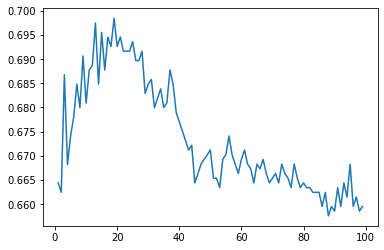

In [216]:
plt.plot(k_range, k_scores)
plt.show()

In [217]:
k_range = range(1,100,2)
params = {
    'n_neighbors' : k_range
}

grid_search = GridSearchCV(neighbors.KNeighborsClassifier(), params, cv=5, return_train_score = True)
grid_search.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 100, 2)},
             return_train_score=True)

In [218]:
grid_search.best_params_

{'n_neighbors': 19}

In [219]:
grid_search.best_score_

0.6984466019417475

In [220]:
model = grid_search.best_estimator_

In [221]:
pred_y=  model.predict(test_x)

In [222]:
cmat = confusion_matrix(test_y, pred_y)
cmat

array([[124,  27],
       [ 52,  54]], dtype=int64)

### 정확도 파악

In [234]:
accuracy_mm = (cmat[0,0] + cmat[1,1]) / np.sum(cmat)
accuracy_mm

0.6926070038910506

In [235]:
roc_auc_score(test_y, pred_y)

0.6653130076221417

### 디스턴스 정하기

In [285]:
k_range = range(1,100,2)
params = {
    'n_neighbors' : k_range,
    'weights' : ['uniform', 'distance']
}

grid_search_N = GridSearchCV(neighbors.KNeighborsClassifier(), params, cv=5, return_train_score = True)
grid_search_N.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 100, 2),
                         'weights': ['uniform', 'distance']},
             return_train_score=True)

In [286]:
grid_search_N.best_params_

{'n_neighbors': 19, 'weights': 'uniform'}

In [287]:
grid_search_N.best_score_

0.6984466019417475

In [239]:
model = grid_search_N.best_estimator_

In [240]:
pred_y=  model.predict(test_x)

In [241]:
cmat = confusion_matrix(test_y, pred_y)
cmat

array([[124,  27],
       [ 52,  54]], dtype=int64)

In [242]:
accuracy_n = (cmat[0,0] + cmat[1,1]) / np.sum(cmat)
accuracy_n

0.6926070038910506

In [243]:
roc_n = roc_auc_score(test_y, pred_y)
roc_n

0.6653130076221417

- 변수의 갯수에 영향을 많이 받음 
- 다중공산성, 변수 선택법과 같은 요소에 달라진다. 
- 스케일링된 데이터들 간의 테스트 정확도를 비교 
- 행 -> 다중공산성, 변수선택법, 일반 변수, 스케일링 변수으로 진행
- 열 -> K값, grid정확도, ACC정확도, roc커브 정확도

In [304]:
std_scaler = MinMaxScaler()
std_scaler_fit = std_scaler.fit(train_x)
train_x_scale = pd.DataFrame(std_scaler_fit.transform(train_x), index=train_x.index, columns=train_x.columns)
test_x_scale = pd.DataFrame(std_scaler_fit.transform(test_x), index = test_x.index, columns=test_x.columns)

In [305]:
k_range = range(1, 100,2)
param = {
    'n_neighbors' : k_range,
    'weights' : ['uniform', 'distance']
}

grid_search_mm = GridSearchCV(neighbors.KNeighborsClassifier(), param, cv=5, return_train_score = True)
grid_search_mm.fit(train_x_scale, train_y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 100, 2),
                         'weights': ['uniform', 'distance']},
             return_train_score=True)

In [306]:
grid_search_mm.best_params_

{'n_neighbors': 17, 'weights': 'uniform'}

In [307]:
grid_search_mm.best_score_

0.7957423632488752

In [308]:
model_mm = grid_search_mm.best_estimator_
model_mm

KNeighborsClassifier(n_neighbors=17)

In [309]:
pred_y_mm = model_mm.predict(test_x_scale)
pred_y_mm 

array([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

In [310]:
cmat_mm = confusion_matrix(test_y, pred_y_mm)
cmat_mm

array([[145,   6],
       [ 42,  64]], dtype=int64)

In [311]:
accuracy_mm = (cmat_mm[0,0] + cmat_mm[1,1])/ np.sum(cmat_mm)
accuracy_mm

0.8132295719844358

In [312]:
roc_mm = roc_auc_score(test_y, pred_y_mm)
roc_mm

0.782019242783956

### min max + vif 

- train_x_scale_vif : minmax로 스케일되었고 vif 처리한 타이타닉 X의 데이터 
- x_train2 : vif처리 후 7:3 처리된 타이타닉의 x 값 
- y_train2 : vif처리 후 7:3 처리된 타이타닉의 y값 


In [292]:
std_scaler = MinMaxScaler()
std_scaler_fit = std_scaler.fit(train_x)
train_x_scale = pd.DataFrame(std_scaler_fit.transform(train_x), index=train_x.index, columns=train_x.columns)
test_x_scale = pd.DataFrame(std_scaler_fit.transform(test_x), index = test_x.index, columns=test_x.columns)

In [335]:
vif = pd.DataFrame()
vif_raw = titanic_features.drop(columns=['Embarked_C', 'Embarked_Q', 'Embarked_S'])
vif['vif factor'] = [variance_inflation_factor(vif_train.values, i) for i in range(0, vif_train.shape[1])]
vif['feature'] = vif_train.columns
vif = round(vif,2)
vif

,vif factor,feature
0,1.69,Pclass
1,1.21,Age
2,1.22,SibSp
3,1.26,Parch
4,1.63,Fare
5,10.50,feamle
6,19.68,male


In [341]:
y = titanic_target
x = vif_raw

x_train2, x_test2, y_train2,  y_test2 = train_test_split(x,y,train_size=0.7, test_size=0.3, random_state=123)

In [346]:
std_scaler = MinMaxScaler()
std_scaler_fit = std_scaler.fit(x_train2)
train_x_scale_vif = pd.DataFrame(std_scaler_fit.transform(x_train2), index=x_train2.index, columns=x_train2.columns)
test_x_scale_vif = pd.DataFrame(std_scaler_fit.transform(x_test2), index = x_test2.index, columns=x_test2.columns)

In [347]:
k_range = range(1, 100,2)
param_vif = {
    'n_neighbors' : k_range,
    'weights' : ['uniform', 'distance']
}

grid_search_mm_vif = GridSearchCV(neighbors.KNeighborsClassifier(), param_vif, cv=5, return_train_score = True)
grid_search_mm_vif.fit(train_x_scale_vif, y_train2)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 100, 2),
                         'weights': ['uniform', 'distance']},
             return_train_score=True)

In [351]:
print(grid_search_mm_vif.best_params_)
print(grid_search_mm_vif.best_score_)

{'n_neighbors': 79, 'weights': 'uniform'}
0.7831160769708255


In [353]:
model_mm_vif = grid_search_mm_vif.best_estimator_
model_mm_vif

KNeighborsClassifier(n_neighbors=79)

In [355]:
pred_y_mm_vif = model_mm_vif.predict(test_x_scale_vif)

In [356]:
cmat_mm_vif = confusion_matrix(y_test2, pred_y_mm_vif)
cmat_mm_vif

array([[212,  23],
       [ 63,  88]], dtype=int64)

In [357]:
accuracy_mm_vif = (cmat_mm_vif[0,0] +cmat_mm_vif[1,1]) / np.sum(cmat_mm_vif)
accuracy_mm_vif

0.7772020725388601

In [358]:
roc_mm_vif = roc_auc_score(y_test2, pred_y_mm_vif)
roc_mm_vif

0.7424545582640552

### min max step
- 모델이 필요한데 rbf모델을 만들어야하나?
- 그러면 C값과 gamma값이 필요한데 
- 지금 이게 제대로 하는건가?

In [366]:
std_scaler = MinMaxScaler()
std_scaler_fit = std_scaler.fit(train_x)
train_x_scale = pd.DataFrame(std_scaler_fit.transform(train_x), index=train_x.index, columns=train_x.columns)
test_x_scale = pd.DataFrame(std_scaler_fit.transform(test_x), index = test_x.index, columns=test_x.columns)

In [373]:
param_rbf = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma' : [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(svm.SVC(kernel = 'rbf'), param_rbf, cv=10, return_train_score = True)
grid_search.fit(train_x_scale, train_y)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True)

In [374]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8054730630116124
{'C': 10, 'gamma': 1}


In [378]:
def checkSubset(x,y,feature_set):
    model = sm.OLS(y, x[list(feature_set)]).fit()
    aic = model.aic
    return {'model' : model, 'AIC' : aic}

In [379]:
def forward(x,y):
    
    selected_columns = []
    
    for i in range(0, x.shape[1]):
        results = []
        forward_columns = [col for col in x.columns if col not in selected_columns]
    
        for col in forward_columns:
            ret = checkSubset(x=x, y=y, feature_set=selected_columns + [col])
            results.append(ret)

        models = pd.DataFrame(results)
        best_model = models.loc[models.AIC.argmin()]
        
        if  i > 0 : 
            if best_model.model.aic > before_model.model.aic: break
            else:
                before_model = best_model
                
        else: 
            #before_aic = best_model.model.aic 
            before_model = best_model
            
        selected_columns = list(best_model.model.params.index)
        #print('selected columns: ', selected_columns, "AIC: ", best_model.model.aic)
        
    return before_model

In [380]:
forward(train_x_scale, y=train_y)

model    <statsmodels.regression.linear_model.Regressio...
AIC                                                983.133
Name: 4, dtype: object

In [381]:
def backward(x,y):
    selected_columns = list(x.columns)
    
    for i in range(0, x.shape[1]):
        results = []

        for combo in itertools.combinations(selected_columns, len(selected_columns)-1):
            backward_columns = list(combo)
            ret = checkSubset(x=x, y=y, feature_set=backward_columns)
            results.append(ret)
        
        models = pd.DataFrame(results)
        best_model = models.loc[models['AIC'].argmin()]
            
        if  i > 0 : 
            if best_model.model.aic > before_model.model.aic: break
            else:
                before_model = best_model
                
        else: 
            before_model = best_model
            
        selected_columns = list(best_model.model.params.index)
        
    return before_model 

In [382]:
backward(train_x_scale, train_y)

model    <statsmodels.regression.linear_model.Regressio...
AIC                                                983.237
Name: 0, dtype: object

In [390]:
def stepwise(x,y):
    selected_columns = []

    for i in range(0, x.shape[1]):
        forward_model = forward_select(x=x, y=y, selected_columns=selected_columns)
        selected_columns = list(forward_model.model.params.index)
        
        if i < 2: before_model = forward_model; continue
            
        small_model = forward_model
        backward_model = backward_drop(x=x, y=y, selected_columns = selected_columns)
        
        if forward_model.model.aic > backward_model.model.aic:
            selected_columns = list(backward_model.model.params.index)
            small_model = backward_model

        if before_model.model.aic > small_model.model.aic:
            before_model = small_model
                
        else:
            break 
            
    return before_model

In [408]:
train_y_pd = pd.DataFrame(train_y)
#type(train_y_pd)
type(train_y_pd)

pandas.core.frame.DataFrame

In [410]:
stepwise(train_x_scale, train_y_pd )

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [365]:
accmatrix = pd.DataFrame(columns = ['K count', 'Accuracy of Grid', 'Accuracy of ACC', 'Roc', ], 
                                  index = ['Normal Var', 'Minmax Var', 'Minmax by Vif'])
accmatrix['K count']['Normal Var'] = grid_search_N.best_params_['n_neighbors']
accmatrix['Accuracy of Grid']['Normal Var'] = grid_search_N.best_score_
accmatrix['Accuracy of ACC']['Normal Var'] = accuracy_n
accmatrix['Roc']['Normal Var'] = roc_n

accmatrix['K count']['Minmax Var'] = grid_search_mm.best_params_['n_neighbors']
accmatrix['Accuracy of Grid']['Minmax Var'] = grid_search_mm.best_score_
accmatrix['Accuracy of ACC']['Minmax Var'] = accuracy_mm
accmatrix['Roc']['Minmax Var'] = roc_mm

accmatrix['K count']['Minmax by Vif'] = grid_search_mm_vif.best_params_['n_neighbors']
accmatrix['Accuracy of Grid']['Minmax by Vif'] = grid_search_mm_vif.best_score_
accmatrix['Accuracy of ACC']['Minmax by Vif'] = accuracy_mm_vif
accmatrix['Roc']['Minmax by Vif'] = roc_mm_vif

accmatrix

,K count,Accuracy of Grid,Accuracy of ACC,Roc
Normal Var,19,0.698447,0.692607,0.665313
Minmax Var,17,0.795742,0.81323,0.782019
Minmax by Vif,79,0.783116,0.777202,0.742455
